# Importing needed libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, InputLayer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import random

# Collab drive mount (Optional)

In [2]:
# I have trained this model on colab with A100 GPU
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading files and creating dataset

In [ ]:
# Reading files and creating dataset
df = pd.read_csv('4.08-7.03.csv')
df = df.drop(columns=["result","table","_start","_stop","_measurement","bucket",
                        "host","topic","Time","Unnamed: 0"])

num_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[num_cols] = df[num_cols].astype('float64')

time_steps = 1 # Every 1 minute will be considered
df = df[0::time_steps]
df.index = range(1,len(df)+1)

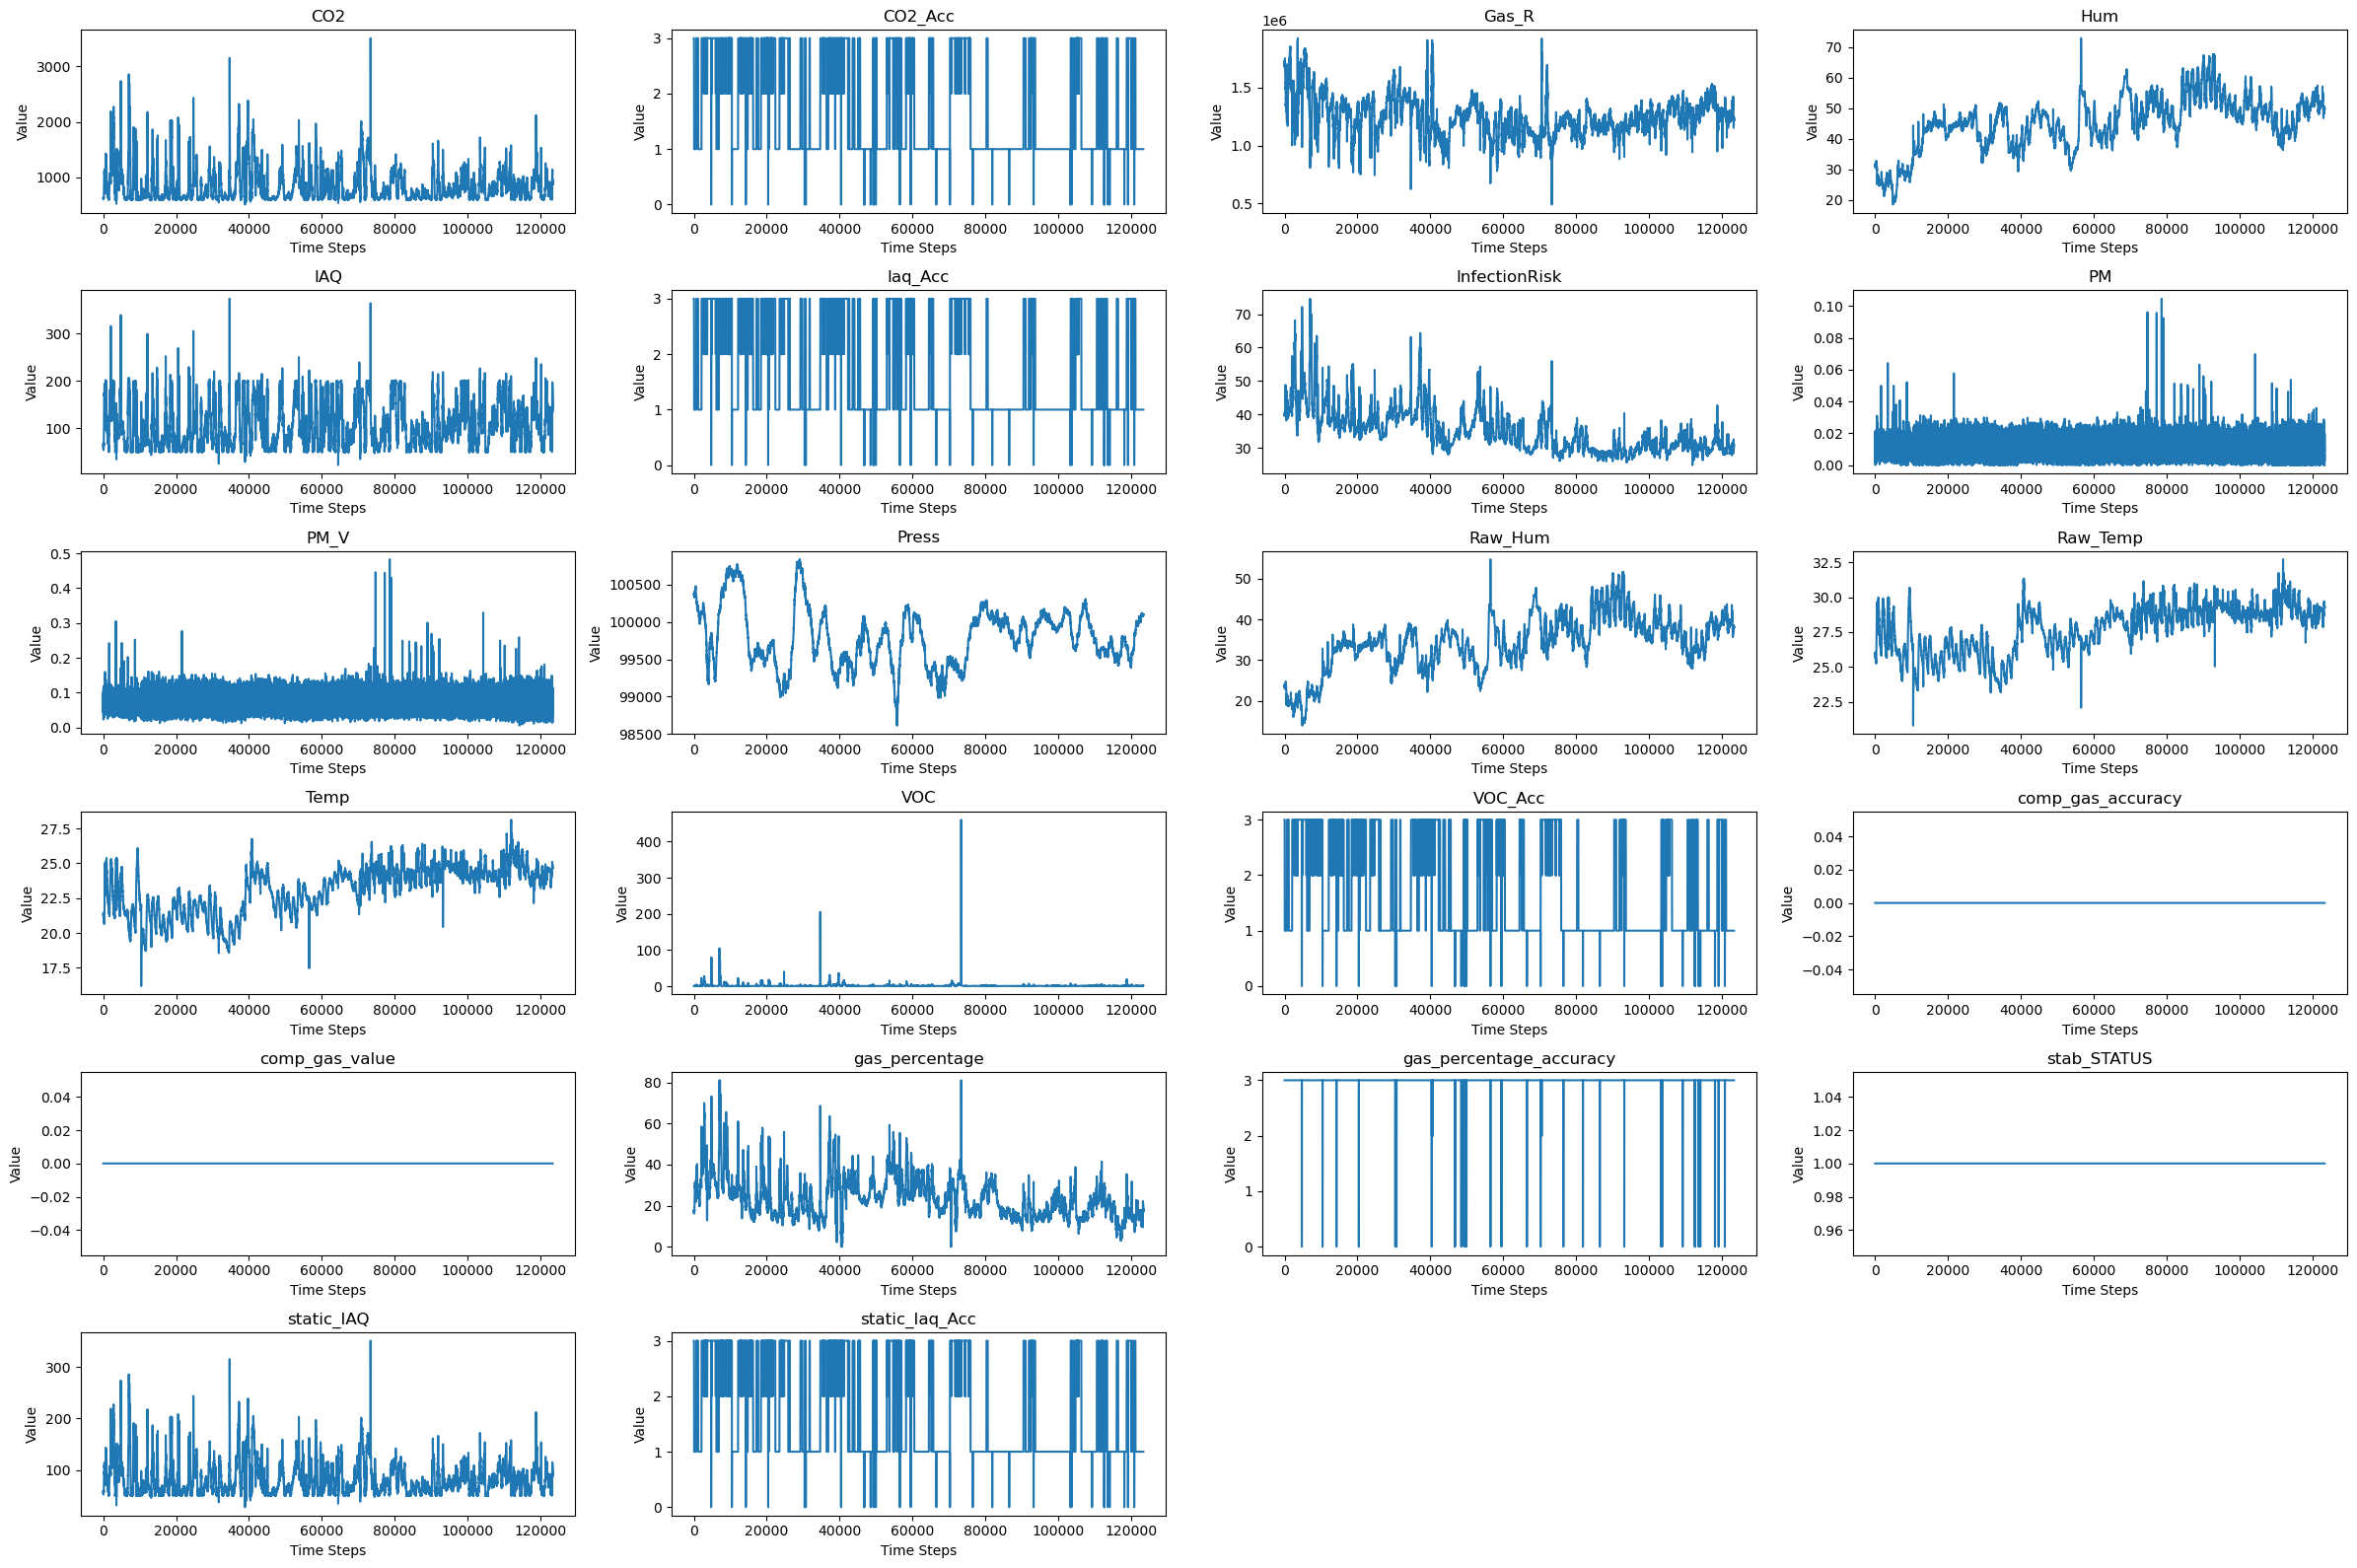

In [78]:
# Plotting all data
cols = df.select_dtypes(include=['float64']).columns
plt.figure(figsize=(24, 16))

for i in range(len(cols)):
    plt.subplot(6, 4, i+1)
    plt.plot(df[cols[i]])
    plt.title(cols[i])
    plt.xlabel('Time Steps')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [ ]:
features = df.drop(columns=["InfectionRisk","_time"]) # Represents X (input)
target = df[["InfectionRisk"]] # Represents y (output)
time = df["_time"].values # Stands for time intervals (4 weeks entirely)
# Scaling data to make training more stable
scaler_X = StandardScaler()
scaler_y = StandardScaler()
scaled_features = scaler_X.fit_transform(features)
scaled_target = scaler_y.fit_transform(target)

# If you have not created a dataset

In [ ]:
# Time step calculations
total_minutes_in_a_day = 60*24
INPUT_WINDOW = (total_minutes_in_a_day//time_steps)*7*3 # represents 3 weeks
OUTPUT_WINDOW = (total_minutes_in_a_day//time_steps)*7*1 # represents next week to be predicted

# Creating data set by stride 1 but 60 minutes time_step !!!
def create_dataset(features, target, time, input_window, output_window, target_column_index=-1):
    X, y, timeline, y_4 = [], [], [], []
    for i in range(len(features) - input_window - output_window + 1):
        input_seq = features[i:(i + input_window):60, :]
        output_seq = target[(i + input_window):(i + input_window + output_window):60, target_column_index]
        whole_sequence = target[i:(i + input_window + output_window):60, target_column_index]
        timeline_seq = time[i:(i + input_window + output_window):60]
        X.append(input_seq)
        y.append(output_seq)
        y_4.append(whole_sequence)
        timeline.append(timeline_seq)
    return np.array(X), np.array(y), np.array(y_4), np.array(timeline)

X, y, y_4, timeline= create_dataset(scaled_features, scaled_target, time, INPUT_WINDOW, OUTPUT_WINDOW, target_column_index=-1)

# Shuffle, if you don't have shuffled indices

In [ ]:
# Shuffle
indices = np.arange(0,X.shape[0])
random.shuffle(indices)
X = X[indices]
y = y[indices]
y_4 = y_4[indices]
timeline = timeline[indices]


# Train and validation arrangement
split_ratio = 0.6
split_time = int(len(X) * split_ratio)
x_train, y_train, y_4_train, timeline_train = X[:split_time], y[:split_time], y_4[:split_time], timeline[:split_time]
x_val, y_val, y_4_val, timeline_val = X[split_time:], y[split_time:], y_4[split_time:], timeline[split_time:]

# If you already have shuffled indices

In [ ]:
indices = np.load("/Users/berat/Desktop/indices.npz")
indices = indices["indices"]

X = X[indices]
y = y[indices]
y_4 = y_4[indices]
timeline = timeline[indices]


# Train and validation arrangement
split_ratio = 0.6
split_time = int(len(X) * split_ratio)
x_train, y_train, y_4_train, timeline_train = X[:split_time], y[:split_time], y_4[:split_time], timeline[:split_time]
x_val, y_val, y_4_val, timeline_val = X[split_time:], y[split_time:], y_4[split_time:], timeline[split_time:]


# Model architecture

In [12]:
model=Sequential()

# Input layer (504, 21)
model.add(InputLayer(shape=(x_train.shape[1], x_train.shape[2])))

# 1st layer (LSTM) (504, 159)
model.add(LSTM(159, return_sequences=True))

# 2nd layer (LSTM) (172)
model.add(LSTM(172))

# 3rd layer (Dense) (123)
model.add(Dense(123, activation='tanh'))

# 4th (Output) layer (168 -> 7*24)
model.add(Dense(168,activation='linear'))

In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 504, 159)       │       115,116 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 172)            │       228,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 123)            │        21,279 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 168)            │        20,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 385,643 (1.47 MB)

 Trainable params: 385,643 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

# Model compilation and metric decision

In [ ]:
# Using mse(Mean Squared Error) as loss metric, PCC(Pearson Correlation Coefficent) and mae(Mean Absolute Error) as evaluation metrics
# Adam optimizer learning rate as -> 0.0051221
cp = tf.keras.callbacks.ModelCheckpoint(filepath="model.keras", monitor="val_pearson_correlation", save_best_only=True, mode="max")
model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(0.0051221), metrics=["mae",tf.keras.metrics.PearsonCorrelation()])

# Model Training

In [ ]:
# epochs -> 69
# batch_size -> 169
history = model.fit(
    x_train,
    y_train,
    epochs=69,
    validation_data=(x_val, y_val),
    verbose=1,
    batch_size=169,
    shuffle=True,
    callbacks=[cp]
)

Epoch 1/69
295/295 ━━━━━━━━━━━━━━━━━━━━ 24s 71ms/step - loss: 0.1817 - mae: 0.2990 - pearson_correlation: 0.5711 - val_loss: 0.0409 - val_mae: 0.1389 - val_pearson_correlation: 0.9070
Epoch 2/69
295/295 ━━━━━━━━━━━━━━━━━━━━ 18s 61ms/step - loss: 0.0358 - mae: 0.1282 - pearson_correlation: 0.9201 - val_loss: 0.0318 - val_mae: 0.1197 - val_pearson_correlation: 0.9302
Epoch 3/69
295/295 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - loss: 0.0278 - mae: 0.1103 - pearson_correlation: 0.9397 - val_loss: 0.0241 - val_mae: 0.1011 - val_pearson_correlation: 0.9478
Epoch 4/69
295/295 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - loss: 0.0231 - mae: 0.0984 - pearson_correlation: 0.9509 - val_loss: 0.0221 - val_mae: 0.0959 - val_pearson_correlation: 0.9527
Epoch 5/69
295/295 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - loss: 0.0214 - mae: 0.0937 - pearson_correlation: 0.9548 - val_loss: 0.0214 - val_mae: 0.0930 - val_pearson_correlation: 0.9560
Epoch 6/69
295/295 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - loss: 0.0199 - mae: 0.08

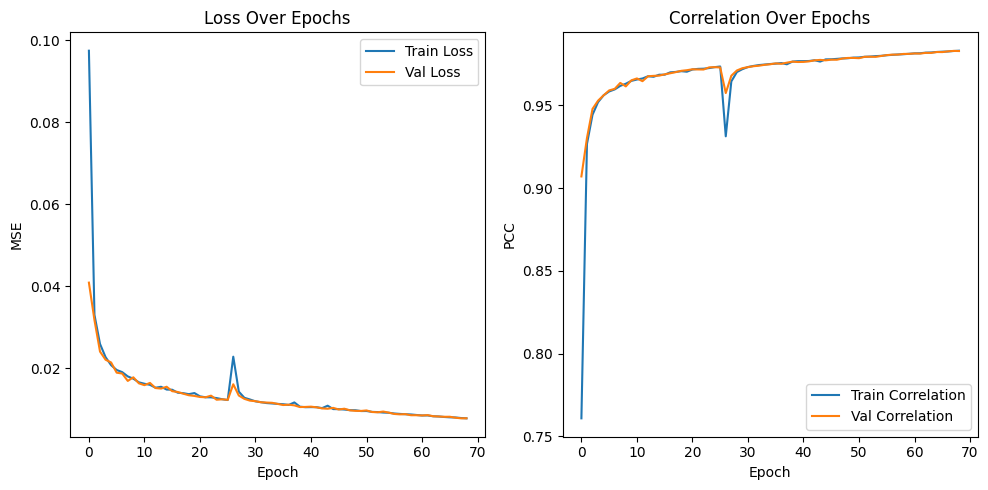

In [16]:
# Plotting Losses and Correlations over epochs
plt.figure(figsize=(10, 5))

# Losses
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

# Correlations
plt.subplot(1, 2, 2)
plt.plot(history.history['pearson_correlation'], label='Train Correlation')
plt.plot(history.history['val_pearson_correlation'], label='Val Correlation')
plt.title('Correlation Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('PCC')
plt.legend()

plt.tight_layout()
plt.show()

# Load trained model if you already have one

In [ ]:
# Once we trained our model and saved it to directory, we can load it rather than training again
loaded_model = tf.keras.models.load_model('model.keras')
loaded_model.summary()

I0000 00:00:1752845190.863406   53534 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1752845190.863438   53534 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 504, 159)       │       115,116 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 172)            │       228,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 123)            │        21,279 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 168)            │        20,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,156,931 (4.41 MB)

 Trainable params: 385,643 (1.47 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 771,288 (2.94 MB)

# Evaluation on validation set

In [62]:
# Evaluation on loaded model (saved model)
loaded_model.evaluate(x_val,y_val)

E0000 00:00:1752846589.633277   53534 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 54s 51ms/step - loss: 0.0078 - mae: 0.0578 - pearson_correlation: 0.9828


[0.00782866682857275, 0.057869404554367065, 0.9827795028686523]

# Plotting ground truth and predicted data

In [41]:
y_pred = loaded_model.predict(x_val)

E0000 00:00:1752845201.575998   53534 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1039/1039 ━━━━━━━━━━━━━━━━━━━━ 56s 53ms/step


In [65]:
def plot_correlation(model, x_val, y_4_val, timeline_val, y_pred=None):

    # Prediction
    if y_pred is None:
        y_pred = model.predict(x_val)
        
    y_4_val_rescaled = scaler_y.inverse_transform(y_4_val)
    y_pred_rescaled = scaler_y.inverse_transform(y_pred)

    # Picking random val index to plot hourly comparisons of the two data
    index = random.randint(0, len(x_val) - 1)

    # Graph adjustments
    y_axis_input = y_4_val_rescaled[index].flatten()
    y_axis_pred = y_pred_rescaled[index].flatten()
    x_axis_val = range(1, 4*len(y_axis_pred)+1)
    x_axis_pred = range(len(y_axis_pred)*3+1, len(y_axis_pred)*4+1)
    
    plt.plot(x_axis_val, y_axis_input, label='Ground truth InfectionRisk', linewidth=2)
    plt.plot(x_axis_pred, y_axis_pred, label='Predicted InfectionRisk')
    plt.title(timeline_val[index][0]+" - "+timeline_val[index][671])
    plt.xlabel("Hours")
    plt.ylabel("InfectionRisk")
    plt.legend()
    plt.grid(True)

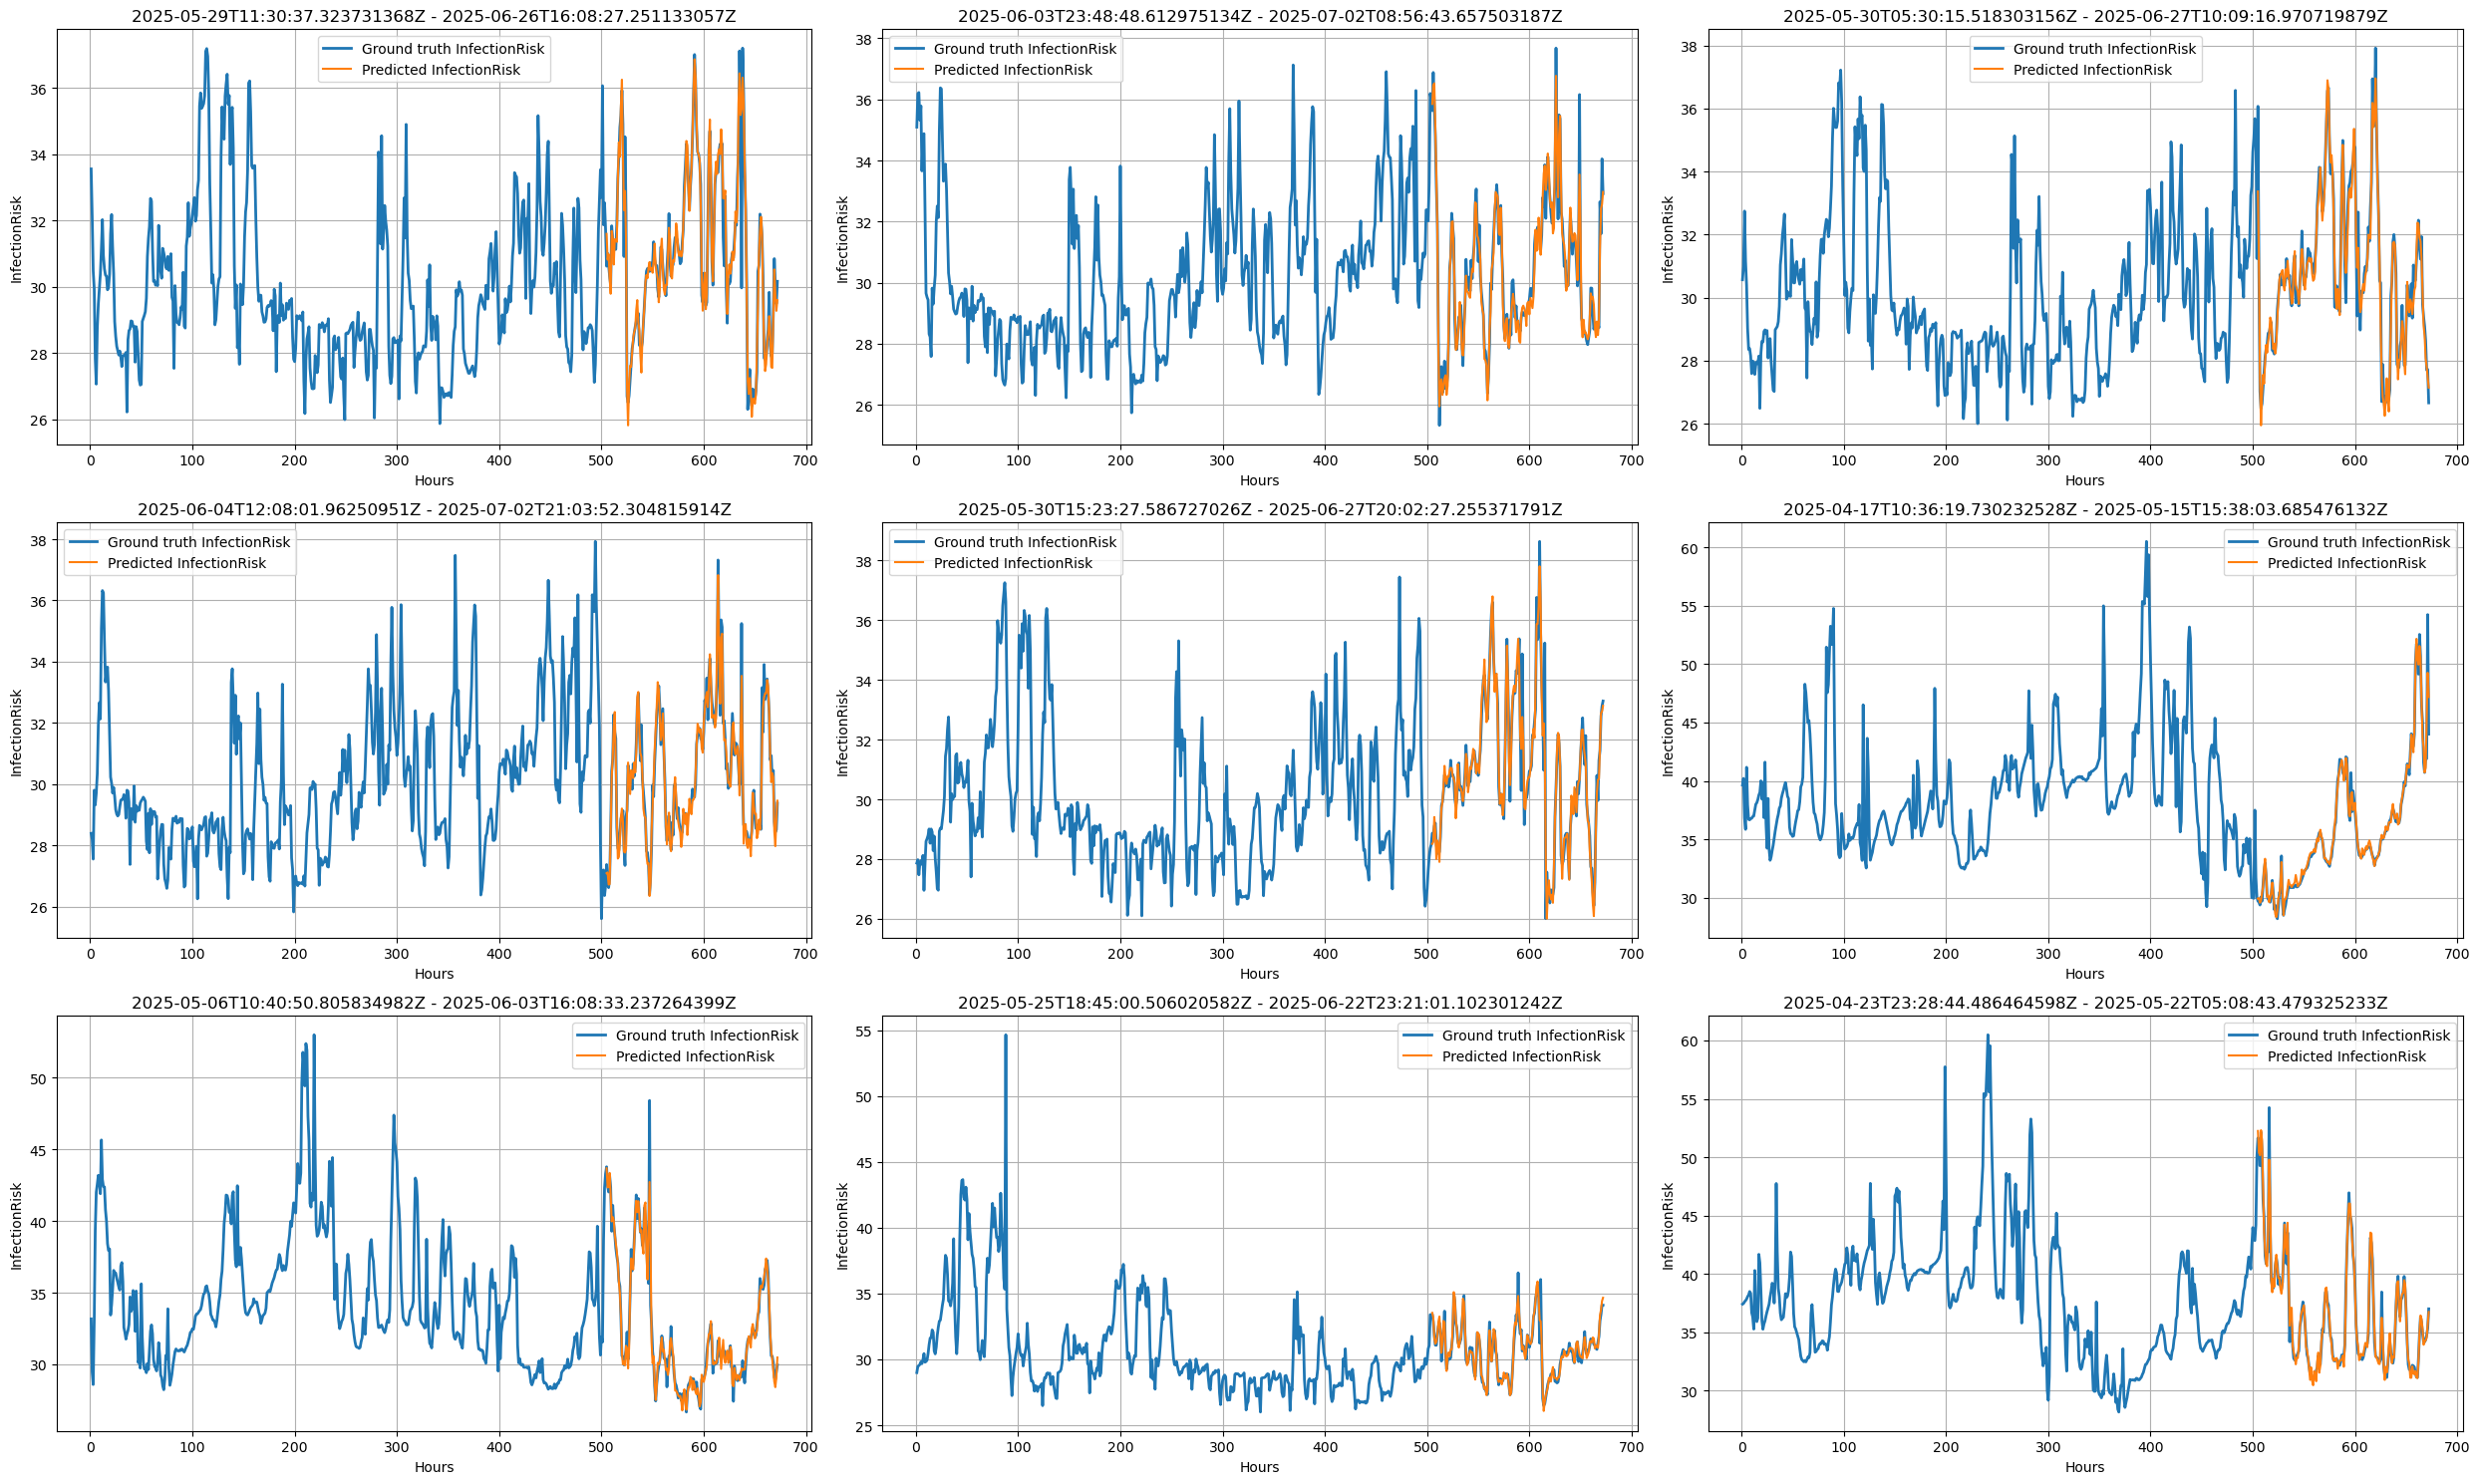

In [66]:
# Setting figure size
plt.figure(figsize=(25, 15))

# Plotting each subgraph
for i in range(9):
    plt.subplot(3, 3, i+1)
    plot_correlation(loaded_model, x_val, y_4_val, timeline_val, y_pred=y_pred)

plt.tight_layout()
plt.show()

# The end...